In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from tqdm import tqdm, trange

In [2]:
filename = 'param-exploration-6.0-6.0-0.2-6.0'
path = '/work/jp464/striatum-sequence/exploration/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']

FileNotFoundError: [Errno 2] No such file or directory: '/work/jp464/striatum-sequence/exploration/param-exploration-6.0-6.0-0.2-6.0.npz'

In [5]:
pd.set_option('display.max_rows', None)
df = pd.read_hdf('/work/jp464/striatum-sequence/output/retrieval_speed.h5', 'data')


In [142]:
from matplotlib.pyplot import figure


def phase_diagram(df, Acb):
    points_att = df[df['Acb']==Acb][df['att']==True].to_numpy()
    points_seq = df[df['Acb']==Acb][df['seq']==True].to_numpy()
    x_att, y_att, x_seq, y_seq = points_att[:,1], points_att[:,0], points_seq[:,1], points_seq[:,0]
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.scatter(x_att, y_att, marker='^')
    ax.scatter(x_seq, y_seq, marker='o')
    ax.set_xlim(0,6.1)
    ax.set_ylim(0,6.1)
    plt.show()

/tmp/ipykernel_431485/1708327493.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  points_att = df[df['Acb']==Acb][df['att']==True].to_numpy()
/tmp/ipykernel_431485/1708327493.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  points_seq = df[df['Acb']==Acb][df['seq']==True].to_numpy()


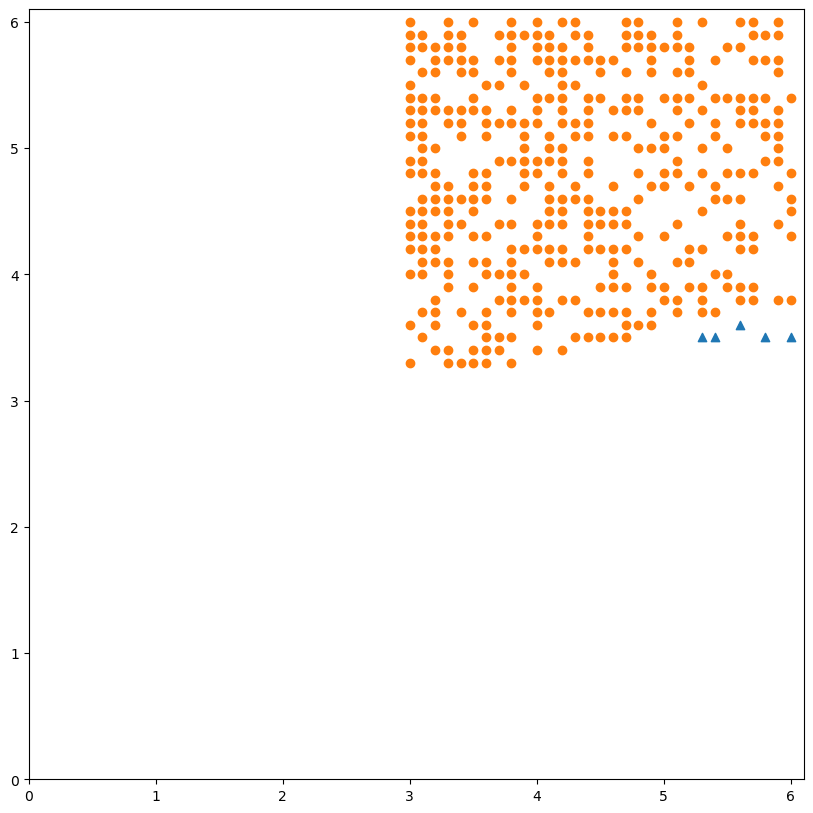

In [145]:
phase_diagram(df, 2)

In [197]:
df.loc[(df['Acb']==0.5) & (df['Abb']==2.0)]

,Acc,Abc,Acb,Abb,v_ctx,v_bg,seq,att
2,2.0,3.2,0.5,2.0,0.0,0.0,False,False
23,2.0,4.6,0.5,2.0,0.0,0.0,False,False
24,2.0,3.0,0.5,2.0,0.0,0.0,False,False
33,2.0,3.9,0.5,2.0,0.0,0.0,False,False
37,2.0,3.6,0.5,2.0,0.0,0.0,False,False
49,2.0,3.7,0.5,2.0,0.0,0.0,False,False
51,2.0,3.8,0.5,2.0,0.0,0.0,False,False
69,2.0,3.1,0.5,2.0,0.0,0.0,False,False
71,2.0,4.7,0.5,2.0,0.0,0.0,False,False
88,2.0,4.0,0.5,2.0,0.0,0.0,False,False


In [41]:
def compute(x, y, z, df):
    target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
    if len(target) == 0:
        return -1 
    return target.iloc[0, -2], target.iloc[0, -1]

def infer(x, y, z, df):
    seq, att = 0, 0
    for i in np.arange(-.4, .4, .1):
        for j in np.arange(-.4, .4, .1):
            score = compute(round(x+i,1), y, round(z+i,1), df)
            if score != -1:
                seq += score[0]
                att += score[1]
    if seq == 0 and att == 0:
        return 0
    elif seq >= att:
        return 10 
    else:
        return 5
    
def compute_score(x, y, z, df):
    x, y, z = round(x, 1), round(y, 1), round(z, 1)
    if x < 3 or z < 2 or y < 0.5:
        return 0
    target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
    cnt = 0
    while len(target) == 0:
        if cnt > 10:
            z += 0.1
        else: z -= 0.1
        z = round(z,1)
        target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
        cnt += 1
    if cnt > 30:
        print(cnt)
    return infer(x,y,z,df)


In [42]:
# Abc, Acb, Abb=Acc
Nx, Ny, Nz =np.arange(0, 6.1, 0.1), np.arange(0, 6.1, 0.5), np.arange(0, 6.1, 0.1)
X, Y, Z = np.meshgrid(Nx, Ny, Nz)
data = np.zeros(X.shape)
ax1, ax2, ax3 = X.shape
for i in trange(ax1):
    for j in range(ax2):
        for k in range(ax3):
            data[i][j][k] = compute_score(X[i][j][k],Y[i][j][k],Z[i][j][k], df)

100%|██████████| 13/13 [13:10<00:00, 60.80s/it]


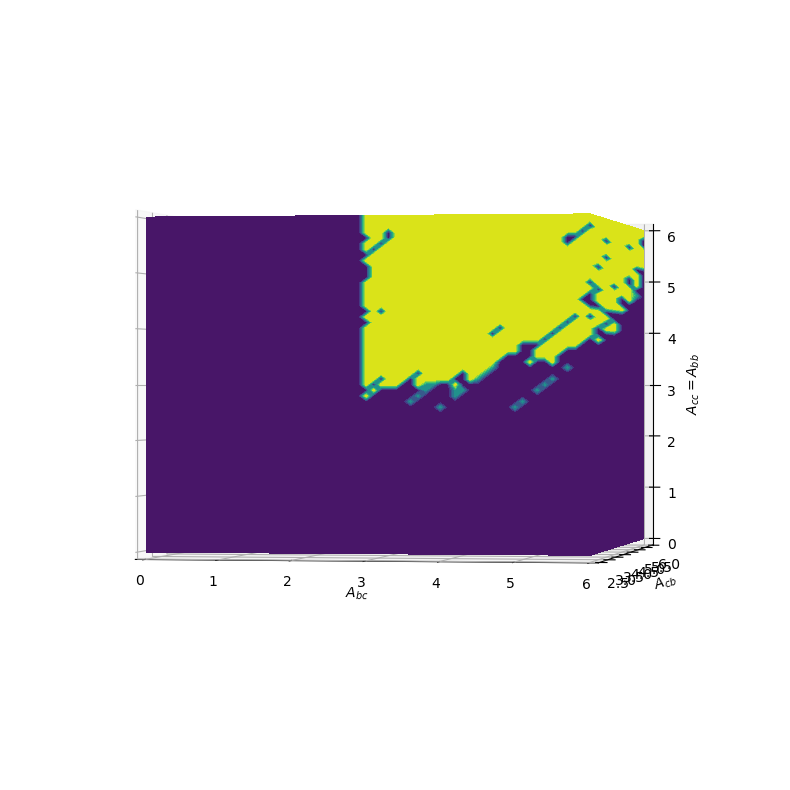

In [122]:
slice = 5
X1, Y1, Z1, data1 = X[slice:13,:,:], Y[slice:13,:,:], Z[slice:13,:,:], data[slice:13,:,:]
kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}


# Create a figure with 3D ax
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X1[:, :, -1], Y1[:, :, -1], data1[:, :, -1],
    zdir='z', offset=Z1.max(), **kw
)
_ = ax.contourf(
    X1[0, :, :], data1[0, :, :], Z1[0, :, :],
    zdir='y', offset=Y1.min(), **kw
)
C = ax.contourf(
    data1[:, -1, :], Y1[:, -1, :], Z1[:, -1, :],
    zdir='x', offset=X1.max(), **kw
)

# Set limits of the plot from coord limits
xmin, xmax = X1.min(), X1.max()
ymin, ymax = Y1.min(), Y1.max()
zmin, zmax = Z1.min(), Z1.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel=r'$A_{bc}$',
    ylabel=r'$A_{cb}$',
    zlabel=r'$A_{cc} = A_{bb}$',
)

# Set zoom and angle view
ax.view_init(0, 280, 0)
# ax.view_init(40, -40, 0)
ax.set_box_aspect(None, zoom=0.9)

# Show Figure
plt.savefig('/work/jp464/striatum-sequence/output/phase-plane5.svg', bbox_inches = "tight", format='svg')

plt.show()